# Assignment 3

This assignment has one main part:

**PCA** : In this part the goal is to implement the dimensionality reduction technique *Principal Component Analysis (PCA)* to a very high dimensional data and apply visualization. Note that you are not allowed to use the built-in PCA API provided by the sklearn library. Instead you will be implementing from the scratch. Use the data in data/train.csv for generating the PCA. See the detailed intructions below.
    

For this task we use the  MovieLens dataset. The data is in train.csv.
   

In [72]:
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.preprocessing import StandardScaler

# Part-1a: Convert data to user-movie rating matrix (10 points)
    - Read the train.csv file and movies.dat file and use user_id and movie_id to create user-movie rating matrix


In [73]:
def readMovieRatingData():
    # TODO Read the user-movie rating in data/train.csv and convert it to a user-movie rating matrix (users in the rows and movies in the colums)
    # Mind the header row in the train.csv
    df = pd.read_csv('data/train.csv')
    return df.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)

In [74]:
user_rating = readMovieRatingData()
user_rating.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
cols = [x for x in user_rating.columns]

In [76]:
def readMovieDeata():
    # Read the movie data from data/movies.dat
    movie_data = pd.read_csv('data/movies.dat', sep='::', header = None, names=['movie_id', 'title', 'genres'])
    movie_data["genres"] = movie_data["genres"].apply(lambda x: x.split('|'))
    return movie_data

In [77]:
movie_data = readMovieDeata()
movie_data.head()

c:\users\rehman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [78]:
# Dropping movies which are not present in user_rating matrix
movie_data = movie_data[movie_data["movie_id"].isin(cols)]
movie_data = movie_data.reset_index(drop=True)

In [79]:
movie_data.shape

(3666, 3)

## We are going to compute PCA for movies so transpose the matrix using X=readMovieRatingData().T


In [80]:
user_rating = user_rating.T
user_rating.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Part-1b: Preprocessing  (10 points)
Before implementing PCA you are required to perform some preprocessing steps:
1. Mean normalization: Replace each feature/attribute, $x_{ji}$ with $x_j - \mu_j$, In other words, determine the mean of each feature set, and then for each feature subtract the mean from the value, so we re-scale the mean to be 0 
2. Feature scaling: If features have very different scales then scale make them comparable by altering the scale, so they all have a comparable range of values e.g. $x_{ji}$ is set to $(x_j - \mu_j) / s_j$  Where $s_j$ is some measure of the range, so could be  $\max(x_j) - \min(x_j)$ or Standard deviation $stddev(x_j)$.

In [81]:
# TODO We can see features have very different scales. So we apply feature scaling with Standard 
# deviation as measure of the range, using StandardScaler from scikit-learn
scaler = StandardScaler()
scaler = scaler.fit(user_rating)
Y = scaler.transform(user_rating)
user_rating_scaled = pd.DataFrame(Y, index = user_rating.index, columns = user_rating.columns)

In [82]:
user_rating_scaled.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,-0.105032,-0.163482,-0.101211,-0.061535,-0.198809,8.251568,-0.078277,-0.171434,8.546444,3.963329,...,-0.096349,6.076739,-0.110287,-0.062546,4.947631,-0.466348,-0.207693,-0.060371,-0.161818,2.818993
2,-0.105032,-0.163482,-0.101211,-0.061535,-0.198809,-0.120465,-0.078277,-0.171434,-0.148473,-0.301793,...,-0.096349,-0.147281,-0.110287,-0.062546,-0.222472,-0.466348,-0.207693,-0.060371,-0.161818,-0.264377
3,-0.105032,-0.163482,-0.101211,-0.061535,-0.198809,-0.120465,-0.078277,-0.171434,-0.148473,-0.301793,...,-0.096349,-0.147281,-0.110287,-0.062546,-0.222472,-0.466348,-0.207693,-0.060371,-0.161818,-0.264377
4,-0.105032,-0.163482,-0.101211,-0.061535,-0.198809,-0.120465,-0.078277,-0.171434,-0.148473,-0.301793,...,-0.096349,-0.147281,-0.110287,-0.062546,2.362579,-0.466348,-0.207693,-0.060371,-0.161818,-0.264377
5,-0.105032,-0.163482,-0.101211,-0.061535,-0.198809,-0.120465,-0.078277,-0.171434,-0.148473,-0.301793,...,-0.096349,-0.147281,-0.110287,-0.062546,1.070053,-0.466348,-0.207693,-0.060371,-0.161818,-0.264377


# Part-2: Covariance matrix  (15 points)
Now the preprocessing is finished. Next, as explained in the lecture, you need to compute the covariance matrix https://en.wikipedia.org/wiki/Covariance_matrix. Given $n \times m$ $n$ rows and $m$ columns matrix, a covariance matrix is an $n \times n$ matrix given as below (sigma)
$\Sigma = \frac{1}{m}\sum{\left(x^{i}\right)\times \left(x^{i}\right)^{T}}$
You may use the "numpy.cov" function in numpy library 

In [83]:
# Compute X to covariance matrix cov_matrix.
cov_matrix = np.cov(user_rating_scaled.T.values)
print(cov_matrix.shape)

(6040, 6040)


# Instructions for part 3, 4, and 5
- getSVD() function is expected to return 3 values. For example: ```U, S, V = getSVD(cov_matrix)```
- You can follow the skeleton below to have an idea on how the autograder's test calls your functions:
```
U, S, V = getSVD(cov_matrix)
z = getKComponents(U, X, k)
ratio = getVarianceRatio(z, U, X, k)
```
- Using the built-in PCA implementation in sklearn, the approximate X matrix can be obtained by function ```inverse_transform```

# Part-3: SVD computation  (10 points)
Now compute the SVD on the covariance matrix $SVD(\Sigma)$. You may use the svd implementation in numpy.linalg.svd

In [84]:
def getSVD(cov_matrix):
    #TODO user np.linalg.svd here
    return np.linalg.svd(cov_matrix, compute_uv = True)

In [85]:
U, S, V = getSVD(cov_matrix)

In [86]:
print(U.shape)
print(S.shape)
print(V.shape)

(6040, 6040)
(6040,)
(6040, 6040)


# Part-4: Compute PCA matrix (K dimensional)  (10 points)
Now select the first $k$ columns from the matrix $U$ and multiply with $X$ to get $k$ dimensional representation.

In [87]:
def getKComponents(U, X, K):
    # implement matrix multiplication of first k columns of U * X
    reducedU = U[:, :K]
    return np.matmul(X, reducedU)

In [88]:
k = 2
Z = getKComponents(U, user_rating_scaled.values, k)
print(Z.shape)

(3666, 2)


# Part-5: Compute Reconstruction Error  (15 points)
Implement a function to compute the variance ratio (from reconstruction error)

In [89]:
def getVarianceRatio(Z, U, X, K):
    #Implement computation of reconstruction error
    x_approx = np.matmul(Z, U[:,:K].T)
    ratio = np.mean((X - x_approx).T.dot(X - x_approx)) / np.mean((X.T).dot(X))
    return ratio

In [90]:
ratio = getVarianceRatio(Z, U, user_rating_scaled.values, k)

In [91]:
print(ratio)

0.0056837412913196056


Compare the variance ration to the built-in PCA implementation in sklearn https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (this step is optional)

In [92]:
X = user_rating_scaled.values

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k)
z_pca = pca.fit_transform(user_rating_scaled)
X_approx_pca = pca.inverse_transform(z_pca)
ratio_pca = np.mean((X-X_approx_pca).T.dot(X-X_approx_pca))/np.mean(X.T.dot(X))
ratio_pca

0.005683737877050165

# Part-6: Scatter plot 2-dimensional PCA  (10 points)
Using matplotlib plot the 2-dimensional scatter plot of the first 2 compoenents with y (movie genre from movies.dat file) as labels. Remember you are plotting movies in dimensions so you can label them with movie generes.

In [94]:
def map_genre(x):
    types = ['Action', 'Animation', 'Comedy', 'Drama', 'Romance', 'Thriller', 'Adventure', 'Sci-Fi', 'War', 'Documentary']
    for t in types:
        if t in x:
            return t
    return 'None'

In [95]:
movie_data['mapped_genre'] =  movie_data.genres.apply(lambda x: map_genre(x))

In [96]:
movie_data.head()

,movie_id,title,genres,mapped_genre
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",Animation
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",Adventure
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",Comedy
4,5,Father of the Bride Part II (1995),[Comedy],Comedy


In [97]:
movie_data.shape

(3666, 4)

In [98]:
import matplotlib.pyplot as plt

def plotFunction(PCA, movie_data):
    labels = np.unique(movie_data.mapped_genre)
    fig, ax = plt.subplots(figsize = (10, 10))
    colors = {'Action': '#000000', 'Animation': '#ff0000', 'Comedy': '#00ff00', 'Drama': '#0000ff', 'Romance': '#ffff00', 'Thriller': '#00ffbf', 'Adventure': '#ffbf00', 'Sci-Fi': '#00bfff', 'War': '#ff00ff', 'Documentary': '#8000ff', 'None': '#f00fff'}
    temp_z = PCA[:, :2]
    for i in labels:
        x = temp_z[(movie_data.loc[movie_data["mapped_genre"] == i]).index][:, 0]
        y = temp_z[(movie_data.loc[movie_data["mapped_genre"] == i]).index][:, 1]
        ax.scatter(x, y, c = colors[i], s = 10, label = i)
    plt.legend()
    plt.show()

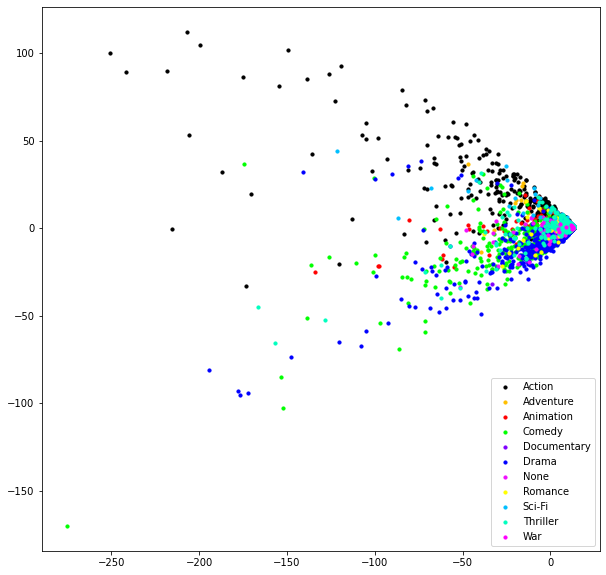

In [99]:
plotFunction(Z, movie_data)

# Part-7 Find best $K$  (10 points)
Find the minimum value of $K$ with which the ratio between averaged squared projection error with total variation in data is less than 0.1% in other words we retain 99.9% of the variance. You can achieve this by repeating getKComponents with $K=1$ until the variance ratio is <= 0.1%.

In [100]:
def findBestK(initial, step):
    #TODO use the getVarianceRatio to find the best K
    for i in range(initial, user_rating.shape[1], step):
        variance_ratio = getVarianceRatio(getKComponents(U, user_rating_scaled.values, i), U, user_rating_scaled.values, i)
        print("Variance Ratio = ", variance_ratio, " with k = ", i)
        if (variance_ratio <= 0.001):
            return i
    return 1

In [101]:
k = findBestK(1, 5)

Variance Ratio =  0.008406455306706393  with k =  1
Variance Ratio =  0.0033452879121846643  with k =  6
Variance Ratio =  0.0013431089594516635  with k =  11
Variance Ratio =  0.0011625448459445873  with k =  16
Variance Ratio =  0.0009864215661194897  with k =  21


# Part-8: TSNE visualization (10 points)
Finally, having found an optimal $K$ use these components as an input data to another dimensionality reduction method called tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) and reduce it to 2 dimensions.

In [102]:
from sklearn.manifold import TSNE
tsne_pca_results = TSNE(n_components = 2, learning_rate = "auto", init = "random").fit_transform(getKComponents(U, user_rating_scaled.values, k))

Finally, scatter plot the components given by the tSNE using matplotlib compare it to the earlier scatter plot.

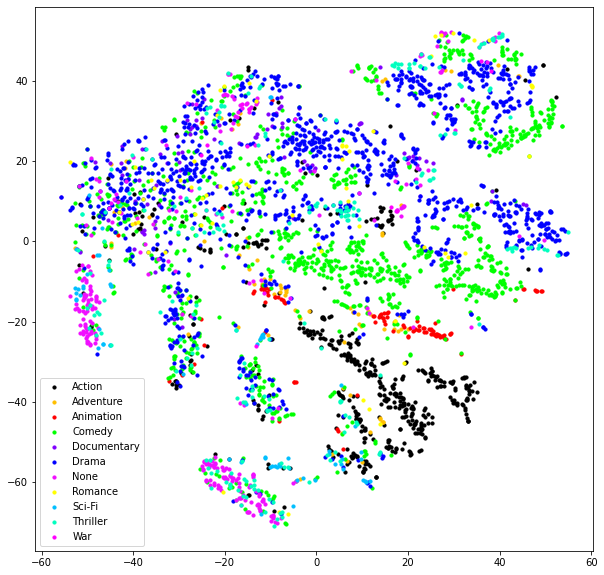

In [103]:
# Scatter plot the 2-dimensional tsne compoents with target as labels
plotFunction(tsne_pca_results, movie_data)